## Import Data
1. Import the data
2. Assign the labels based on the dataset description

In [1]:
import pandas as pd

df = pd.read_csv('data/UNSW-NB15_4.csv')

df.columns = ['srcip',    'sport',    'dstip',    'dsport',    'proto',    'state',    'dur',    'sbytes',    'dbytes',    'sttl',    'dttl',    'sloss',    'dloss',    'service',    'sload',    'dload',    'spkts',    'dpkts',    'swin',    'dwin',    'stcpb',    'dtcpb',    'smeansz',    'dmeansz',    'trans_depth',    'res_bdy_len',    'sjit',
                        'djit',    'Stime',    'ltime',    'dintpkt',    'dintpkt',    'tcprtt',    'synack',    'ackdat',    'is_sm_ips_ports',    'ct_state_ttl',    'ct_flw_http_mthd',    'is_ftp_login',    'ct_ftp_cmd',    'ct_srv_src',    'ct_srv_dst',    'ct_dst_ltm',    'ct_src_ltm',    'ct_src_dport_ltm',    'ct_dst_sport_ltm',    'ct_dst_src_ltm',    'attack_cat',    'label']
df.head()

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.9,9685,149.171.126.2,80,tcp,FIN,5.864748,19410,1087890,31,...,,3,1,4,4,1,1,1,NaN,0
1,59.166.0.2,1421,149.171.126.4,53,udp,CON,0.001391,146,178,31,...,,3,5,2,7,1,1,4,NaN,0
2,59.166.0.2,21553,149.171.126.2,25,tcp,FIN,0.053948,37812,3380,31,...,,1,1,4,7,1,1,3,NaN,0
3,59.166.0.8,45212,149.171.126.4,53,udp,CON,0.000953,146,178,31,...,,2,5,2,1,1,1,2,NaN,0
4,59.166.0.0,59922,149.171.126.8,6881,tcp,FIN,8.633186,25056,1094788,31,...,,9,7,2,3,2,1,6,NaN,0


We will be using unsupervised models, so we discard any labels

In [2]:
df = df.drop(['attack_cat', 'label'], axis = 1)

The dataset if very use, so we will just use a subset for our experiment

In [3]:
sample = df.sample(50_000, random_state=42)
sample.head()

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm
178777,149.171.126.14,1043,175.45.176.1,53,udp,INT,0.000003,264,0,60,...,NaN,NaN,,39,39,18,18,18,18,39
178937,149.171.126.14,1043,175.45.176.1,53,udp,INT,0.000007,264,0,60,...,NaN,NaN,,42,42,42,42,42,23,42
339242,59.166.0.8,54347,149.171.126.1,25541,tcp,FIN,0.372510,4296,3080,31,...,NaN,NaN,,3,5,4,1,1,1,1
314795,149.171.126.10,47439,175.45.176.0,53,udp,INT,0.000005,264,0,60,...,NaN,NaN,,42,42,42,42,42,16,42
239837,175.45.176.2,26297,149.171.126.15,80,tcp,FIN,0.725453,910,268,254,...,1.0,NaN,,1,1,1,2,1,1,1


## Preprocessing

### Discretization
Convert nominal data to numeric (We will use One-Hot-Encoding) <br><br>
Note : Ports may be treated as numerical attributes in cases where the focus of the analysis is on the volume of traffic and not on the specific ports. Also, treating ports as categorial and applying OHE would escalate the number of attribues,so we con't treat port numbers as categorical.

In [4]:

nominal_cols = ['srcip', 'dstip', 'proto']
sample = pd.get_dummies(sample, columns=nominal_cols)

In [5]:
sample.dtypes

sport              int64
dsport            object
state             object
dur              float64
sbytes             int64
                  ...   
proto_wsn          uint8
proto_xnet         uint8
proto_xns-idp      uint8
proto_xtp          uint8
proto_zero         uint8
Length: 241, dtype: object

### Cleaning and Numeric Conversion

1. We will convert all the data in the dataframe to numeric and keep any invalid/missing data as NaN.
2. If there exists columns with only NaN values or almost all Nan Values, we will drop them.
3. If there exists rows with NaN values, we will drop them.

In [6]:
import numpy as np
# convert columns to numeric data types
sample = sample.apply(pd.to_numeric, errors='coerce')
sample.shape

(50000, 241)

In [7]:
# Remove the columns for which all the values are NaN
sample = sample.dropna(axis = 1, how = 'all')
sample.shape

(50000, 239)

In [8]:
sample.columns[sample.isnull().any()]

Index(['dsport', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd'], dtype='object')

In [9]:
sample['ct_flw_http_mthd'].isnull().sum(), sample['is_ftp_login'].isnull().sum(), sample['ct_ftp_cmd'].isnull().sum()

(46189, 49263, 49263)

In [10]:
#'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd' have a lot of null values, so we discard themm
sample = sample.drop(['ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd'], axis = 1)

In [11]:
sample['dsport'].isnull().sum()

9

In [12]:
# We discard the rows with null values as dsport seems to have some of them
sample = sample.dropna()
sample.shape

(49991, 236)

In [13]:
sample.head()

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,sload,...,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero
178777,1043,53.0,0.000003,264,0,60,0,0,0,3.520000e+08,...,0,0,0,0,0,0,0,0,0,0
178937,1043,53.0,0.000007,264,0,60,0,0,0,1.508571e+08,...,0,0,0,0,0,0,0,0,0,0
339242,54347,25541.0,0.372510,4296,3080,31,29,7,7,8.897480e+04,...,0,0,0,0,0,0,0,0,0,0
314795,47439,53.0,0.000005,264,0,60,0,0,0,2.112000e+08,...,0,0,0,0,0,0,0,0,0,0
239837,26297,80.0,0.725453,910,268,254,252,2,1,9.031598e+03,...,0,0,0,0,0,0,0,0,0,0


### Standardization
We will standardize the data before performing PCA to help bring all the features to the same scale  and avoids any feature dominating others during the PCA process.

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standard_sample = scaler.fit_transform(sample)

In [15]:
standard_sample[:10]

array([[-1.31940043, -0.51814953, -0.15622553, ..., -0.0077469 ,
        -0.00894543, -0.00894543],
       [-1.31940043, -0.51814953, -0.15622443, ..., -0.0077469 ,
        -0.00894543, -0.00894543],
       [ 1.18783939,  0.98558202, -0.05406021, ..., -0.0077469 ,
        -0.00894543, -0.00894543],
       ...,
       [ 0.86291044, -0.51814953, -0.15622443, ..., -0.0077469 ,
        -0.00894543, -0.00894543],
       [ 0.86291044, -0.51814953, -0.15622416, ..., -0.0077469 ,
        -0.00894543, -0.00894543],
       [-1.31940043, -0.51814953, -0.15622471, ..., -0.0077469 ,
        -0.00894543, -0.00894543]])

### Dimension Redunction

1. We will use Scree plot to determine the number of components that can identify the "elbow" or point where the decrease in eigenvalues slows down.
2. We will then find the principal components based on the scree plot and transform our data to those dimensions

#### Scree Plot

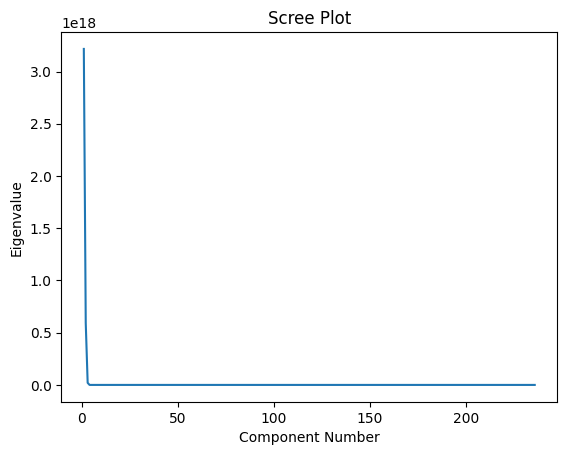

The number of components to retain based on the scree plot is 2


In [16]:
# Reduce the dimention of the attributes

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Conduct PCA and calculate the eigenvalues for each component
pca = PCA()
pca.fit(sample)
eigenvalues = pca.explained_variance_

# Plot the scree plot
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker=None)
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()

# Determine the number of components to retain based on the scree plot
total_variance = sum(eigenvalues)
variance_explained = [(i / total_variance) for i in sorted(eigenvalues, reverse=True)]
cumulative_variance_explained = np.cumsum(variance_explained)
num_components = np.argmax(cumulative_variance_explained >= 0.99) + 1

print(f"The number of components to retain based on the scree plot is {num_components}")

#### PCA

In [17]:
from sklearn.decomposition import PCA

# Set the number of components to retain
n_components = num_components

# Conduct PCA and transform the data
pca = PCA(n_components=n_components)
sample_transformed = pca.fit_transform(sample)

In [18]:
sample_transformed[:, 0]

array([-1.47843015e+09, -1.47228510e+09, -1.48189601e+08, ...,
        2.20261540e+09, -1.46767715e+09, -1.24166730e+09])

### Visualize

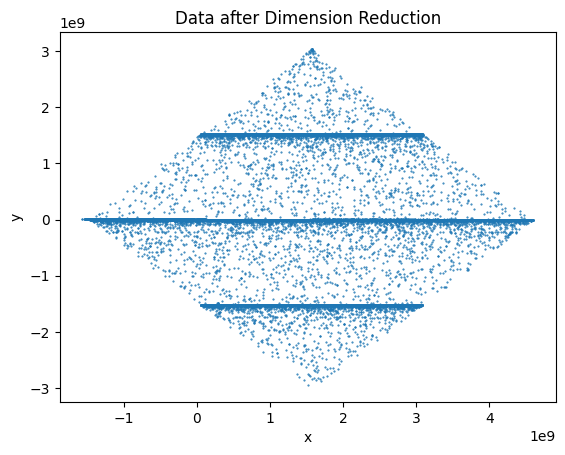

In [19]:
import matplotlib.pyplot as plt

plt.scatter(sample_transformed[:, 0], sample_transformed[:, 1], marker='.',s = 1)
    

# Set the plot title and axis labels
plt.title('Data after Dimension Reduction')
plt.xlabel('x')
plt.ylabel('y')

# Show the plot
plt.show()

### Standardization Round 2
Performing scaling after PCA helps to bring down the magnitude of the principal components, which can be very large after PCA, without losing any information

In [20]:

from sklearn.preprocessing import StandardScaler

# assuming X is your data matrix
scaler = StandardScaler()
standard_sample = scaler.fit_transform(sample_transformed)

In [21]:
standard_sample[:10]

array([[-0.82435587,  0.0035694 ],
       [-0.82092947,  0.00348746],
       [-0.08262884, -0.04816642],
       [-0.82195739,  0.00351204],
       [ 0.54709339,  1.20509148],
       [-0.81937201,  0.00345021],
       [-0.82195739,  0.00351204],
       [-0.82092947,  0.00348746],
       [-0.81933064,  0.00344922],
       [-0.82135777,  0.0034977 ]])

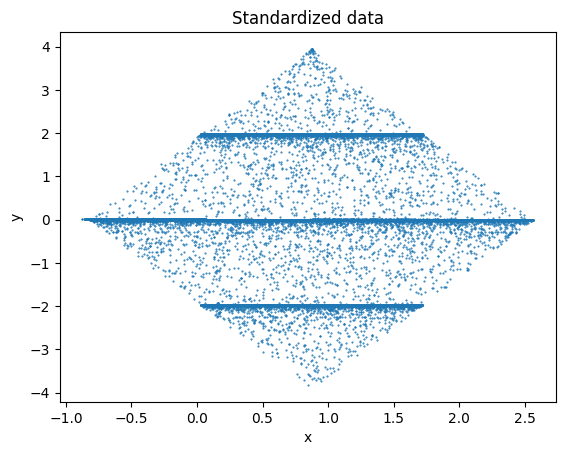

In [22]:
import matplotlib.pyplot as plt

plt.scatter(standard_sample[:, 0], standard_sample[:, 1], marker='.',s = 1)


# Set the plot title and axis labels
plt.title('Standardized data')
plt.xlabel('x')
plt.ylabel('y')

# Show the plot
plt.show()

## Export the processed data

In [23]:
# Use the transformed data for further analysis or modeling
# Save it in a file
import pandas as pd
transformed_df = pd.DataFrame(standard_sample)

transformed_df.to_csv('./data/processed_data.csv', header=None, index=None)